<a href="https://colab.research.google.com/github/sinood/cs194-26_proj4_p3/blob/master/Neural_Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import time
import cv2
import scipy.stats as st
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import copy

DEVICE = torch.device("cuda")
# device = torch.device("cpu")
SIZE = 256
PATH = '/content/drive/MyDrive/cs194-26_finalproj_ims/'

Loss functions

In [73]:


def get_gram_mat(input):
    batchsize, num_features, feature_rows, feature_cols = input.size()
    features = input.view(batchsize*num_features, feature_rows*feature_cols)
    gram_mat = torch.mm(features, features.t())
    gram_mat = gram_mat.div(batchsize*num_features*feature_rows*feature_cols)
    return gram_mat

class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = get_gram_mat(target_feature).detach()

    def forward(self, input):
        gram_mat = get_gram_mat(input)
        self.loss = F.mse_loss(gram_mat, self.target)
        return input

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, im):
        return (im - self.mean) / self.std

def insert_loss_layers(model, im_content, im_style,
                content_loss_layers=['conv_4'],
                style_loss_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    model = copy.deepcopy(model)
    normalize = Normalize(mean=torch.tensor([0.40760392, 0.45795686, 0.48501961]).to(DEVICE),
                          std=torch.tensor([1,1,1]).to(DEVICE))
    new_model = nn.Sequential(normalize)

    losses_content = []
    losses_style = []
    i = 0
    for layer in model.children():
        name = ""
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
          print("layer type unknown: ",layer)
        new_model.add_module(name, layer)

        if name in content_loss_layers:
            target = new_model(im_content).detach()
            content_loss = ContentLoss(target)
            new_model.add_module("content_{}".format(i), content_loss)
            losses_content.append(content_loss)

        if name in style_loss_layers:
            target_feature = new_model(im_style).detach()
            style_loss = StyleLoss(target_feature)
            new_model.add_module("style_{}".format(i), style_loss)
            losses_style.append(style_loss)

    # Don't want the remaining layers, just the loss layers we added, so clip the rest
    last_layer = i
    for j in range(len(new_model)-1,-1,-1):
        if isinstance(new_model[i], ContentLoss) or isinstance(new_model[i], StyleLoss):
            last_layer = j
            break
    new_model = new_model[:last_layer+1]

    return new_model, losses_content, losses_style



In [23]:
model = models.vgg19(pretrained=True).features
model = model.to(DEVICE)
model = model.eval()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Image loading 

In [75]:
# Need to make images same size and convert them to tensors
im_adjust = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor()])
im_convert = transforms.ToPILImage()

def imload(imname):
    im = Image.open(imname)
    im = im_adjust(im)
    im = im.unsqueeze(0)
    return im.to(DEVICE, torch.float)

def display_tensor_im(im_tensor):
    plt.figure()
    im = im_tensor.cpu().clone()
    im = im_convert(im.squeeze(0))
    plt.imshow(im)


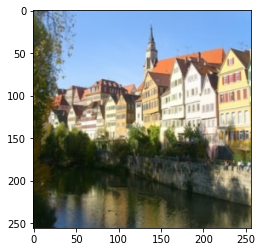

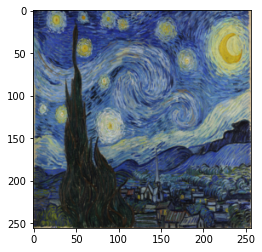

In [76]:
content_im = imload(PATH+'neckarfront.jpg')
style_im = imload(PATH+'starrynight.jpg')
display_tensor_im(content_im)
display_tensor_im(style_im)

In [77]:
model_modified, loss_content, loss_style = insert_loss_layers(model, content_im, style_im)
# print(loss_style)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
